In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import re
import unicodedata
import nltk
from nltk.corpus import stopwords
from tensorflow import keras
from tensorflow.keras.layers import Dense,Dropout, Input, Reshape
from tqdm import tqdm
import pickle
from sklearn.metrics import confusion_matrix,f1_score,classification_report
import matplotlib.pyplot as plt
import itertools
from sklearn.utils import shuffle
from tensorflow.keras import regularizers
from transformers import *
from transformers import BertTokenizer, TFBertModel, BertConfig,TFDistilBertModel,DistilBertTokenizer,DistilBertConfig
import numpy as np
import pandas as pd
from sklearn import preprocessing 
import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [ ]:
!pip install numpy requests nlpaug
import pandas as pd
import numpy as np
import nlpaug.augmenter.word as nlpaw
from tqdm import tqdm

     |████████████████████████████████| 405 kB 4.3 MB/s eta 0:00:01


In [ ]:
!pip install transformers==3.0.0

     |████████████████████████████████| 754 kB 4.4 MB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 30.3 MB/s eta 0:00:01
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.10.3
    Uninstalling tokenizers-0.10.3:
      Successfully uninstalled tokenizers-0.10.3
  Attempting uninstall: transformers
    Found existing installation: transformers 4.6.1
    Uninstalling transformers-4.6.1:
      Successfully uninstalled transformers-4.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
allennlp 2.5.0 requires transformers<4.7,>=4.1, but you have transformers 3.0.0 which is incompatible.


In [ ]:
def dataframe_creation():
    col_list=['Loc','Pred','Sent','Topic','Speaker','Position','Region','Party','a','b','c','d','e','Occasion']
    df_4 = pd.read_csv('../input/newsdatasets/other_dataset/other_dataset/LIAR/valid.tsv',header = None,sep='\t')
    df_2 = pd.read_csv('../input/newsdatasets/other_dataset/other_dataset/LIAR/test.tsv',header = None,sep='\t')
    df_3 = pd.read_csv('../input/newsdatasets/other_dataset/other_dataset/LIAR/train.tsv',header = None,sep='\t')
    df_4 = pd.concat([df_2,df_3,df_4],ignore_index=True)
    df_4.columns =  col_list
    
    return df_4

df = dataframe_creation()
print(df.shape)
le = preprocessing.LabelEncoder()
df.drop(df.columns.difference(['Pred','Sent']), 1, inplace=True)
df.head()

(12791, 14)


,Pred,Sent
0,true,Building a wall on the U.S.-Mexico border will...
1,false,Wisconsin is on pace to double the number of l...
2,false,Says John McCain has done nothing to help the ...
3,half-true,Suzanne Bonamici supports a plan that will cut...
4,pants-fire,When asked by a reporter whether hes at the ce...


In [ ]:
df.shape

(12791, 2)

In [ ]:
df['Pred'].value_counts(normalize = True)

half-true      0.205379
false          0.195997
mostly-true    0.191854
barely-true    0.164412
true           0.160503
pants-fire     0.081854
Name: Pred, dtype: float64

<AxesSubplot:>

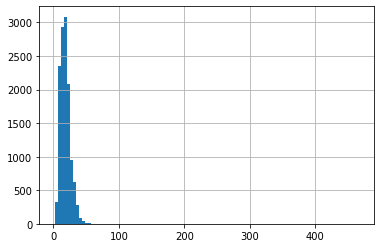

In [ ]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in df['Sent']]

pd.Series(seq_len).hist(bins = 100)

In [ ]:
max_len = 30

From the above we can conclude that there are 10,675 data sample with 150 character or max len 30 and 2000 data sample with max len 467. This creates a huge sparse matrix which inturn stumbles the modelling analysis

In [ ]:
df.head()

,Pred,Sent
0,true,Building a wall on the U.S.-Mexico border will...
1,false,Wisconsin is on pace to double the number of l...
2,false,Says John McCain has done nothing to help the ...
3,half-true,Suzanne Bonamici supports a plan that will cut...
4,pants-fire,When asked by a reporter whether hes at the ce...


In [ ]:
df.groupby('Pred').count()

,Sent
Pred,
barely-true,2103
false,2507
half-true,2627
mostly-true,2454
pants-fire,1047
true,2053


In [ ]:
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as nafc
from nlpaug.util import Action
X = df.loc[df['Pred'] == 'pants-fire']['Sent'].tolist()
Y = df.loc[df['Pred'] == 'pants-fire']['Pred'].tolist()
aug = naw.SynonymAug(aug_src='wordnet')
augmented_text = aug.augment(X)
X = df['Sent'].tolist()
X= X + augmented_text
Y1 = df['Pred'].tolist()
Y1 = Y1 + Y
df = pd.DataFrame(list(zip(X,Y1)),
               columns =['Sent', 'Pred'])

In [ ]:
df.shape

(13838, 2)

In [ ]:
df.groupby('Pred').count()

,Sent
Pred,
barely-true,2103
false,2507
half-true,2627
mostly-true,2454
pants-fire,2094
true,2053


# Data Augmentation

## 1. Synonym Replacement :
Synonym replacement is a technique in which we replace a word by one of its synonyms

For identifying relevent Synonyms we use WordNet

## 2.Random Deletion (RD)
In Random Deletion, we randomly delete a word if a uniformly generated number between 0 and 1 is smaller than a pre-defined threshold. This allows for a random deletion of some words of the sentence.

## 3. Random Swap (RS)
In Random Swap, we randomly swap the order of two words in a sentence.

## 4. Random Insertion (RI)
Finally, in Random Insertion, we randomly insert synonyms of a word at a random position.

Data augmentation operations should not change the true label of a sentence, as that would introduce unnecessary noise into the data. Inserting a synonym of a word in a sentence, opposed to a random word, is more likely to be relevant to the context and retain the original label of the sentence.



Link to Paper : https://arxiv.org/abs/1901.11196

Repo Link : https://github.com/jasonwei20/eda_nlp

In [ ]:
from nltk.corpus import wordnet
import random
from nltk.corpus import stopwords
stop_words = []
for w in stopwords.words('english'):
    stop_words.append(w)
print(stop_words)
def synonym_replacement(words, n):
    
    words = words.split()
    
    new_words = words.copy()
    random_word_list = list(set([word for word in words if word not in stop_words]))
    random.shuffle(random_word_list)
    num_replaced = 0
    
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        
        if len(synonyms) >= 1:
            synonym = random.choice(list(synonyms))
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        
        if num_replaced >= n: #only replace up to n words
            break

    sentence = ' '.join(new_words)

    return sentence
def get_synonyms(word):
    
    synonyms = set()
    
    for syn in wordnet.synsets(word):
        for l in syn.lemmas():
            synonym = l.name().replace("_", " ").replace("-", " ").lower()
            synonym = "".join([char for char in synonym if char in ' qwertyuiopasdfghjklzxcvbnm'])
            synonyms.add(synonym) 
    if word in synonyms:
        synonyms.remove(word)
    
    return list(synonyms)
def random_deletion(words, p):

    words = words.split()
    
    #obviously, if there's only one word, don't delete it
    if len(words) == 1:
        return words

    #randomly delete words with probability p
    new_words = []
    for word in words:
        r = random.uniform(0, 1)
        if r > p:
            new_words.append(word)

    #if you end up deleting all words, just return a random word
    if len(new_words) == 0:
        rand_int = random.randint(0, len(words)-1)
        return [words[rand_int]]

    sentence = ' '.join(new_words)
    
    return sentence
def swap_word(new_words):
    
    random_idx_1 = random.randint(0, len(new_words)-1)
    random_idx_2 = random_idx_1
    counter = 0
    
    while random_idx_2 == random_idx_1:
        random_idx_2 = random.randint(0, len(new_words)-1)
        counter += 1
        
        if counter > 3:
            return new_words
    
    new_words[random_idx_1], new_words[random_idx_2] = new_words[random_idx_2], new_words[random_idx_1] 
    return new_words

# This will Swap the words
def random_swap(words, n):
    
    words = words.split()
    new_words = words.copy()
    # n is the number of words to be swapped
    for _ in range(n):
        new_words = swap_word(new_words)
        
    sentence = ' '.join(new_words)
    
    return sentence
def random_insertion(words, n):
    
    words = words.split()
    new_words = words.copy()
    
    for _ in range(n):
        add_word(new_words)
        
    sentence = ' '.join(new_words)
    return sentence

def add_word(new_words):
    
    synonyms = []
    counter = 0
    
    while len(synonyms) < 1:
        random_word = new_words[random.randint(0, len(new_words)-1)]
        synonyms = get_synonyms(random_word)
        counter += 1
        if counter >= 10:
            return
        
    random_synonym = synonyms[0]
    random_idx = random.randint(0, len(new_words)-1)
    new_words.insert(random_idx, random_synonym)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [ ]:
def aug(sent,n,p):
    print(f" Original Sentence : {sent}")
    print()
    print()
    print(f" SR Augmented Sentence : {synonym_replacement(sent,n)}")
    print()
    print()
    print(f" RD Augmented Sentence : {random_deletion(sent,p)}")
    print()
    print()
    print(f" RS Augmented Sentence : {random_swap(sent,n)}")    
    print()
    print()
    print(f" RI Augmented Sentence : {random_insertion(sent,n)}")    
    print()
    print()
    
trial_sent = df['Sent'][6]
aug(trial_sent,4,0.3)

 Original Sentence : Says that Tennessee law requires that schools receive half of proceeds -- $31 million per year -- from a half-cent increase in the Shelby County sales tax.


 SR Augmented Sentence : enounce that tennessee law want that schools receive half of proceeds -- $31 million per twelvemonth -- from a half-cent increase in the Shelby County sales tax.


 RD Augmented Sentence : that Tennessee law requires schools receive of proceeds -- $31 year -- from a half-cent in Shelby sales tax.


 RS Augmented Sentence : Says million Tennessee law County that of receive half schools proceeds -- $31 year per that -- from a half-cent increase in the Shelby requires sales tax.


 RI Augmented Sentence : Says that Tennessee law requires that schools receive half of proceeds wages -- $31 million per year -- from payoff a half-cent increase in the one half payoff Shelby County sales tax.




In [ ]:
def aug(sent , op , n ,p):
    return [sent,synonym_replacement(sent,n),random_deletion(sent,p),random_swap(sent,n),random_insertion(sent,n)],[op,op,op,op,op]
aug(df['Sent'][6],df['Pred'][6],4,0.3)

(['Says that Tennessee law requires that schools receive half of proceeds -- $31 million per year -- from a half-cent increase in the Shelby County sales tax.',
  'Says that Tennessee practice of law requires that civilise receive half of proceeds -- $31 million per year -- from a half-cent increment in the Shelby county sales tax.',
  'Says that Tennessee that schools receive of -- $31 million per -- from a increase in the Shelby County sales',
  'Says that Tennessee law requires that schools from half of proceeds County $31 million per -- -- receive a half-cent increase in sales Shelby year the tax.',
  'Says that Tennessee law requires that schools receive sale half of proceeds -- $31 million per year growth -- from a train half-cent increase in the Shelby County sales payoff tax.'],
 ['true', 'true', 'true', 'true', 'true'])

In [ ]:
X = df['Sent'].tolist()
Y = df['Pred'].tolist()
X_new = []
Y_new = []
for i in tqdm(range(len(X))):
    x , y= aug(X[6],Y[i],4,0.3)
    X_new = X_new + x
    Y_new = Y_new + y
len(X_new),len(Y_new)

100%|██████████| 13838/13838 [00:13<00:00, 1058.98it/s]


(69190, 69190)

In [ ]:
dfaug = pd.DataFrame(list(zip(X_new,Y_new)),
               columns =['Sent', 'Pred'])
print(dfaug.shape)
dfaug.groupby('Pred').count()

(69190, 2)


,Sent
Pred,
barely-true,10515
false,12535
half-true,13135
mostly-true,12270
pants-fire,10470
true,10265


In [ ]:
dfaug.to_csv('df_aug.csv',index=False)
dfaug.head()

,Sent,Pred
0,Says that Tennessee law requires that schools ...,true
1,articulate that Tennessee natural law requires...,true
2,Says that Tennessee law requires that receive ...,true
3,sales that Tennessee County requires that scho...,true
4,Says that Tennessee law requires that constabu...,true


In [ ]:
dfaug.groupby('Pred').count()

,Sent
Pred,
barely-true,10515
false,12535
half-true,13135
mostly-true,12270
pants-fire,10470
true,10265
